# Import necessary libraries



## Drive + pip install

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/ML/SentimentAnalysis"

/content/drive/MyDrive/ML/SentimentAnalysis


In [3]:
!pip install datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

## Other libraries

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import math
import os
import numpy as np

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Config

In [6]:
max_token_length= 128
embeddings_size = 256
num_layers = 6
dropout_rate = 0.6
hidden_size = 50

learning_rate = 2e-5
weight_decay = 1e-3

batch_size = 32

# Data preprocessing

In [7]:
from datasets import load_dataset
dataset = load_dataset('glue', 'sst2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
def preprocess_function(examples):
    return tokenizer(examples["sentence"], padding='max_length', truncation=True, max_length=max_token_length)

In [10]:
tokenized_train = dataset["train"].map(preprocess_function, batched=True)
tokenized_val = dataset["validation"].map(preprocess_function, batched=True)
tokenized_test = dataset["test"].map(preprocess_function, batched=True)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [11]:
tmp_data = np.array(tokenized_train["input_ids"])
vocab_size = np.max(tmp_data) + 1
tmp_data = None

In [12]:
tmp_data = np.array(tokenized_train["label"])
num_classes = np.max(tmp_data) + 1
tmp_data = None

In [13]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data["input_ids"]
        self.label = data["label"]
        self.length = len(self.label)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        torch_data = torch.tensor(self.data[index], dtype=torch.int64)
        torch_label = torch.tensor(self.label[index], dtype=torch.int64)

        return (torch_data, torch_label)

In [14]:
torch_dataset_train = CustomDataset(tokenized_train)
torch_dataset_val = CustomDataset(tokenized_val)
torch_dataset_test = CustomDataset(tokenized_test)

In [15]:
torch_train_loader = DataLoader(torch_dataset_train, batch_size=batch_size, shuffle=True)
torch_val_loader = DataLoader(torch_dataset_val, batch_size=batch_size, shuffle=True)
torch_test_loader = DataLoader(torch_dataset_test, batch_size=batch_size, shuffle=True)

# Model

In [16]:
def init_lstm_weights(lstm, low=-0.08, high=0.08):
    for name, param in lstm.named_parameters():
        if 'weight' in name:
            nn.init.uniform_(param, low, high)
        elif 'bias' in name:
            nn.init.zeros_(param)

        return lstm

In [17]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers, drop_out):
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.dropout = nn.Dropout(drop_out)
        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size,
                              padding_idx=0,
                              max_norm=None,
                              norm_type=2.0,
                              scale_grad_by_freq=False,
                              sparse=False)

        self.rnn = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers, dropout=drop_out)

        self.rnn = init_lstm_weights(self.rnn)

    def forward(self, x):
        # x: input shape (seq_max_len, batch_size)
        #print(x.shape)
        embeddings_pre_dropout = self.embeddings(x)

        #print(embeddings_pre_dropout.shape)

        #print(embeddings_pre_dropout.is_leaf)
        #print(x.is_leaf)
        #print(embeddings_pre_dropout.mean().backward())

        embeddings = self.dropout(embeddings_pre_dropout)
        #print(embeddings.is_leaf)

        output, (hidden, cell) = self.rnn(embeddings)

        return hidden, cell

In [18]:
class EncoderClassification(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers, drop_out, num_classes):
        super(EncoderClassification, self).__init__()

        self.encoder = Encoder(vocab_size, embedding_size, hidden_size, num_layers, drop_out)
        self.fc1 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, cell = self.encoder(x)

        x = cell[-1::].squeeze(0)

        x = self.fc1(x)

        return x


In [20]:
import matplotlib.pyplot as plt

torch.Size([32, 2])


<ipython-input-29-f43affdd05ec>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor((input.clone().detach()[0, :]<0.5), dtype=torch.int64)


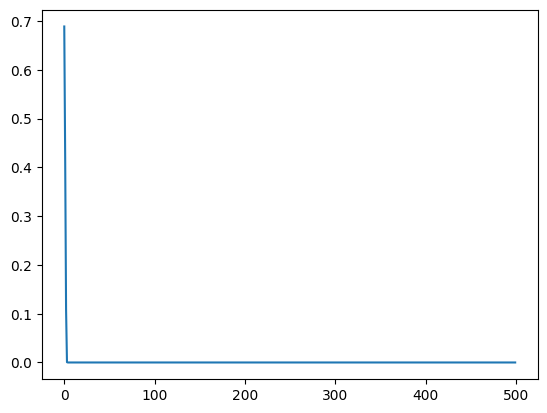

In [29]:
net = EncoderClassification(vocab_size, embeddings_size, hidden_size, num_layers, dropout_rate, num_classes)
x = torch.randint(size=(10, 32), low=1, high=10)
out = net(x)
print(out.shape)

optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 500

loss_hist = []
net.train()
for epoch in range(1, epochs+1):
    input = torch.randint(size=(10, 32), low=1, high=10)
    target = torch.tensor((input.clone().detach()[0, :]<0.5), dtype=torch.int64)
    optimizer.zero_grad()
    out = net(input)
    #print(out.shape)
    #print(target.shape)
    #print(out.dtype)
    #print(target.dtype)
    loss = criterion(out, target)
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())
plt.plot(loss_hist)
plt.show()

# Train

## Initialize, load, save model

In [31]:
def init_model():
    model = EncoderClassification(vocab_size, embeddings_size, hidden_size, num_layers, dropout_rate, num_classes)

    #class_weights = torch.tensor(100 * np.ones(model.vocab_len), dtype=torch.float32)
    #class_weights[esp_words_dict["<pad>"]] = torch.tensor(1e-6, dtype=torch.float32)
    #class_weights[esp_words_dict["<sos>"]] = torch.tensor(1, dtype=torch.float32)
    #class_weights[esp_words_dict["<eos>"]] = torch.tensor(1, dtype=torch.float32)
    #class_weights[esp_words_dict["<unk>"]] = torch.tensor(1, dtype=torch.float32)

    #print(class_weights)

    criterion = nn.CrossEntropyLoss().to(device=device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    return model, criterion, optimizer

def save_model(model, optimizer, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

def load(model, optimizer, path):
    checkpoint = torch.load(path, map_location=torch.device(device))

    print(type(checkpoint["model_state_dict"]))

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]

    return model, optimizer, epoch

## Actual training loop

In [32]:
def summary(loader, model, criterion):
    num_correct = 0
    num_samples = 0
    total_loss = 0
    loss_epoch = 0
    loss_avg = 0

    model.eval()

    acc = 0

    with torch.no_grad():
        for index, (data, label) in enumerate(loader):
            data = data.to(device=device)
            label = label.to(device=device)

            data = torch.moveaxis(data, 0, 1)

            prob = model(data)

            #print(prob.shape)

            pred = torch.argmax(prob, dim=1)

            current_correct = (pred == label).sum()

            num_correct += current_correct
            num_samples += data.shape[1]

            #print(prob, label)

            loss = criterion(prob, label)

            loss_epoch += loss.item()

        acc = float(num_correct)/float(num_samples) * 100.0
        loss_avg = float(loss_epoch)/float(len(loader))
    return acc, loss_avg

In [33]:
def train(train_loader, val_loader, num_epochs, batch_print=40):
    train_acc_list = []
    train_loss_list = []

    val_acc_list = []
    val_loss_list = []

    cur_epoch = -1

    model, criterion, optimizer = init_model()

    numpy_final_result = [[] for _ in range(20)]

    MODEL_SAVE_PATH = os.path.join(os.getcwd(), "eval/encoder_no_attention.pt")
    JSON_SAVE_PATH = os.path.join(os.getcwd(), "eval/encoder_no_attention.json")

    if os.path.exists(MODEL_SAVE_PATH):
        model, optimizer, cur_epoch = load(model, optimizer, path=MODEL_SAVE_PATH)

        #with open(NUMPY_SAVE_PATH, 'rb') as f:
        #    numpy_final_result = pickle.load(f)

        ### LOAD MODEL ###

    for epoch in range(num_epochs):
        if cur_epoch >= epoch:
            continue

        correct_samples = 0
        total_samples = 0

        loss_epoch = 0

        print("----------------------------------------")

        model.train()

        for batch_idx, (data, label) in enumerate(train_loader):
            data = data.to(device=device)
            label = label.to(device=device)
            data = torch.moveaxis(data, 0, 1)

            optimizer.zero_grad()

            prob = model(data)

            loss = criterion(prob, label)
            loss.backward()
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)

            pred = torch.argmax(prob, dim=1)
            current_correct = (pred == label).sum().item()
            correct_samples += current_correct
            total_samples += data.shape[1]
            loss_epoch += loss.item()


            if batch_idx % batch_print == batch_print - 1:
                print(f"Batch {batch_idx + 1}: Accuracy: {float(current_correct) / float(data.shape[1]) * 100.0}")
                print(f"Loss: {loss.item()}")
                save_model(model=model, optimizer=optimizer, epoch=epoch, path=MODEL_SAVE_PATH)

        # Validation
        val_acc, val_loss = summary(val_loader, model, criterion)

        train_acc_list.append(float(correct_samples) / float(total_samples + 1e-12) * 100.0)
        train_loss_list.append(float(loss_epoch) / float(len(train_loader)))

        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        #for i in range(20):
        #    numpy_final_result[i].extend(final_result[i])
        #    print(f"Prob for {i + 1}: min {np.min(numpy_final_result[i])}, max: {np.max(numpy_final_result[i])}")

        if epoch % 1 == 0:
            save_model(model=model, optimizer=optimizer, epoch=epoch, path=MODEL_SAVE_PATH)

        cur_epoch = epoch

        print(f"Epoch {epoch + 1}:")

        print(f"Train accuracy: {train_acc_list[-1]}%")
        print(f"Train loss: {train_loss_list[-1]}")

        print(f"Val accuracy: {val_acc_list[-1]}%")
        print(f"Val loss: {val_loss_list[-1]}")

In [ ]:
train(torch_train_loader, torch_val_loader, num_epochs=50, batch_print=50)

<class 'collections.OrderedDict'>
----------------------------------------
Batch 50: Accuracy: 37.5
Loss: 0.7290038466453552
Batch 100: Accuracy: 53.125
Loss: 0.6948752403259277
Batch 150: Accuracy: 50.0
Loss: 0.6984970569610596
Batch 200: Accuracy: 62.5
Loss: 0.6706295609474182
Batch 250: Accuracy: 59.375
Loss: 0.6780778169631958
Batch 300: Accuracy: 62.5
Loss: 0.6689670085906982
Batch 350: Accuracy: 56.25
Loss: 0.6867800951004028
Batch 400: Accuracy: 53.125
Loss: 0.6936566829681396
Batch 450: Accuracy: 43.75
Loss: 0.7119867205619812
Batch 500: Accuracy: 50.0
Loss: 0.7005865573883057
Batch 550: Accuracy: 50.0
Loss: 0.70210200548172
Batch 600: Accuracy: 50.0
Loss: 0.6992794275283813
Batch 650: Accuracy: 46.875
Loss: 0.7050469517707825
Batch 700: Accuracy: 56.25
Loss: 0.6820282936096191
Batch 750: Accuracy: 68.75
Loss: 0.6565293073654175
Batch 800: Accuracy: 46.875
Loss: 0.7066709995269775
Batch 850: Accuracy: 59.375
Loss: 0.6769105195999146
Batch 900: Accuracy: 65.625
Loss: 0.662924408

KeyboardInterrupt: 